In [1]:
# import libraries
import plotly.express as px
import plotly.graph_objects as go

import random
import pickle

from keras.layers import TextVectorization
from tensorflow import keras
from keras import layers
import tensorflow as tf

from scipy import sparse
from scipy.sparse import csr_matrix, vstack

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [17]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import re
import random
import nltk
from scipy import sparse
from scipy.sparse import csr_matrix, vstack
from textblob import TextBlob 
import pickle
from datetime import datetime

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import sys
# sys.path.append('../Data preprocessing') 
# import simple_feature_engineering as sf

In [ ]:
# #Load the data
# df = pd.read_csv('../Datasets/translated.csv')
# df.head()

In [19]:
#Load the data
df = pd.read_csv('/content/drive/MyDrive/translated.csv')
df.head()

,Artist,Song,Translated_Lyrics
0,ԱՐԹՈՒՐ ՄԵՍՉՅԱՆ,ԱՀԱ ԵՎ ՎԵՐՋ,Here is an end\n\r\nEnd of paragraphs and last...
1,ԱՐԹՈՒՐ ՄԵՍՉՅԱՆ,ԱՄԵՆԸ ՁԵԶ,Large-scale and wonderful temples\n\r\nAnd the...
2,ԱՐԹՈՒՐ ՄԵՍՉՅԱՆ,ԱՆԱՌԱԿ ՈՐԴՈՒ ՎԵՐԱԴԱՐՁԸ,When like a prodigal son\n\r\nBecome your own ...
3,ԱՐԹՈՒՐ ՄԵՍՉՅԱՆ,ԱՇԽԱՐՀԻ ՑԱՎՈՎ,My heart with Kariy's world pain\n\r\nHow much...
4,ԱՐԹՈՒՐ ՄԵՍՉՅԱՆ,ԱՌԱՋ ԳԻՏԵԻ,I was known before\n\r\nWhat people would be a...


In [20]:
df["Artist"].value_counts()

ՌՈՒԲԵՆ ՀԱԽՎԵՐԴՅԱՆ     85
ԿՈՄԻՏԱՍ               64
ԱՐԹՈՒՐ ՄԵՍՉՅԱՆ        50
Harout Pamboukjian    40
Misho                 29
Լիլիթ Հովհաննիսյան    27
Սիրուշո               27
Հայկ Հակոբյան         25
Arsen Safaryan        24
Razmik Amyan          23
Silva Hakobyan        20
Միհրան Ծառուկյան      19
Aram MP3              18
HT Hayko              16
ՍԱՅԱԹ-ՆՈՎԱ            16
Mi Qani Hogi          16
Անդրե                 12
Empyray               11
Arame                 11
 Lav Eli              10
Name: Artist, dtype: int64

In [21]:
def preprocessing_func(df):
    """
    Perform preprocessing steps on a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to be preprocessed.

    Returns:
        pandas.DataFrame: The preprocessed DataFrame.

    """
    # Drop rows with any NaN values
    df.dropna(how='any', inplace=True)
    df = df[df['Song'] != 'Տնից Պախել Եմ (Tnits Paxhel Em)']

    # After dropping the rows, you can reset the index if needed
    df.reset_index(drop=True, inplace=True)

    # Replace newline, carriage return, and tab characters with a space
    df['Translated_Lyrics'] = df['Translated_Lyrics'].str.replace(r'\n|\r|\t', ' ', regex=True)
    df['Translated_Lyrics'] = df['Translated_Lyrics'].astype(str)

    # Rename columns
    df.rename(columns={'Artist': 'artist', 'Translated_Lyrics': 'text', 'Song': 'song'}, inplace=True)

    return df

In [22]:
def stem_from_tokens(df, column_name):
    """
    Apply stemming to tokens in a DataFrame column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the column with tokens.
        column_name (str): The name of the column containing the tokens.

    Returns:
        pandas.DataFrame: The DataFrame with an additional column containing the stemmed tokens.

    """
    # Initialize the stemmer
    stemmer = nltk.stem.porter.PorterStemmer()
    token_to_stem = {}
    token_count = 0  # Initialize word count

    # Iterate through all songs
    for lst in df[column_name]:
        # Iterate through all tokens of a song
        for token in lst:
            token_count += 1
            # Check if token is in the dictionary
            if token not in token_to_stem:
                # Add token to the dictionary with its stem
                token_to_stem[token] = stemmer.stem(token)

    # Map the tokens to their stems in a new column
    df['stems'] = df[column_name].map(lambda lst: [token_to_stem[token] for token in lst])
    df['stems_str'] = df['stems'].map(lambda lst: ' '.join(lst))

    return df

In [23]:
def encode_labels(df, label_column):
    """
    Encode labels in a DataFrame column using LabelEncoder.

    Args:
        df (pandas.DataFrame): The DataFrame containing the label column.
        label_column (str): The name of the column containing the labels.

    Returns:
        pandas.DataFrame: The DataFrame with an additional column containing the encoded labels.

    """
    label_encoder = LabelEncoder()
    df['target'] = label_encoder.fit_transform(df[label_column])
    return df,label_encoder

In [24]:
def make_bached_dataset(batch_size, df):
    """
    Create batched TensorFlow datasets for training and testing.

    Args:
        batch_size (int): The batch size for the datasets.
        df (pandas.DataFrame): The DataFrame containing the dataset.

    Returns:
        tuple: A tuple containing the training and testing datasets.
               Each dataset is a TensorFlow dataset object.

    """
    random.seed(42)
    
    targets = df['target'].to_numpy()

    train_idx, valid_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2,
        shuffle=True,
        stratify=targets
    )

    train = df.iloc[train_idx]
    test = df.iloc[valid_idx]

    X_train = train["stems_str"]
    y_train = train["target"]
    X_test = test["stems_str"]
    y_test = test["target"]

    # Create TensorFlow datasets from X_train and y_train
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, test_dataset, y_test

In [25]:
def make_vectorized_dataset(max_tokens, train_dataset, test_dataset):
    """
    Create a vectorized dataset using TextVectorization.

    Args:
        max_tokens (int): The maximum number of tokens to consider in the vectorization process.
        train_dataset (tf.data.Dataset): The training dataset.
        test_dataset (tf.data.Dataset): The testing dataset.

    Returns:
        tuple: A tuple containing the vectorized training and testing datasets.

    """
    text_vectorization = TextVectorization(
        max_tokens=max_tokens,
        output_mode="multi_hot"
    )

    text_only_train_ds = train_dataset.map(lambda x, y: x)
    text_vectorization.adapt(text_only_train_ds)

    train_ds = train_dataset.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )

    test_ds = test_dataset.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )

    return train_ds, test_ds

In [26]:
def get_model(max_tokens):
    """
    Create a neural network model.

    Args:
        max_tokens (int): The number of input tokens.

    Returns:
        tensorflow.keras.Model: The compiled neural network model.

    """

    random.seed(42)

    inputs = keras.Input(shape=(max_tokens,))
    features = layers.Dense(256, activation="relu")(inputs)
    features = layers.Dense(256, activation="relu")(features)
    features = layers.BatchNormalization()(features)
    features = layers.Dense(128, activation="relu")(features)
    features = layers.Dense(128, activation="relu")(features)
    features = layers.BatchNormalization()(features)
    features = layers.Dense(64, activation="relu")(features)
    features = layers.BatchNormalization()(features)
    outputs = layers.Dense(20, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)


    # inputs = keras.Input(shape=(1,max_tokens))
    # x = layers.SimpleRNN(16, return_sequences=True)(inputs)
    # x = layers.SimpleRNN(16, return_sequences=True)(x)
    # outputs = layers.SimpleRNN(20)(x)

    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [27]:
def model_fit(model, train_ds, test_ds, path):
    """
    Fit a neural network model to the training dataset and evaluate it on the testing dataset.

    Args:
        train_ds (tf.data.Dataset): The training dataset.
        test_ds (tf.data.Dataset): The testing dataset.
        path (str): The path to save the best model checkpoint.

    Returns:
        tuple: A tuple containing the trained model and the accuracy string.

    """
    
    callbacks = [
        keras.callbacks.ModelCheckpoint(path, save_best_only=True)
    ]

    model.fit(
        train_ds.cache(),
        validation_data=test_ds.cache(),
        epochs=5,
        callbacks=callbacks
    )

    model = keras.models.load_model(path)
    accuracy = f"Test acc: {model.evaluate(test_ds)[1]:.3f}"
    return model, accuracy

In [28]:
def model_predict(model, test_ds):
    """
    Make predictions using a trained neural network model.

    Args:
        model (tensorflow.keras.Model): The trained model.
        test_ds (tf.data.Dataset): The dataset to make predictions on.

    Returns:
        numpy.ndarray: The predicted labels.

    """
    y_pred = np.argmax(model.predict(test_ds), axis=1)
    return y_pred

In [29]:
def tokenize_column(df, column_name, language='en'):
    """
    Tokenizes a specified column of a DataFrame based on the specified language.

    Args:
        df (DataFrame): The DataFrame to process.
        column_name (str): The name of the column to tokenize.
        language (str): The language of the column content ('en' for English, 'hy' for Armenian).

    Returns:
        DataFrame: The input DataFrame with a new column containing the tokenized values.

    Raises:
        ValueError: If the specified column_name does not exist in the DataFrame or the language is not supported.

    Example:
        df = pd.DataFrame({'lyrics': ['This is a sentence.', 'Այս հանդիպումը մի հատված է.']})
        tokenize_column(df, 'lyrics', 'en')
        # Resulting DataFrame:
        #                       lyrics              tokens_en
        # 0         This is a sentence.   [This, is, a, sentence, .]
        # 1  Այս հանդիպումը մի հատված է:  [Այս, հանդիպումը, մի, հատված, է, :]
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    if language not in ['en', 'hy']:
        raise ValueError("Unsupported language. Choose 'en' for English or 'hy' for Armenian.")
        
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    if language == 'en':
        df['tokens_en'] = df[column_name].map(tokenizer.tokenize)
    elif language == 'hy':
        df['tokens_hy'] = df[column_name].map(tokenizer.tokenize)

    return df

In [30]:
#Preprocess the data
df = preprocessing_func(df)

<ipython-input-21-7afd08a2cfd1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Translated_Lyrics'] = df['Translated_Lyrics'].str.replace(r'\n|\r|\t', ' ', regex=True)
<ipython-input-21-7afd08a2cfd1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Translated_Lyrics'] = df['Translated_Lyrics'].astype(str)
<ipython-input-21-7afd08a2cfd1>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [31]:
#Tokenize text column
df = tokenize_column(df, 'text' , language='en')

In [32]:
#Stemming
df = stem_from_tokens(df,'tokens_en')

In [33]:
#Drop unnecessary columns
df.drop(["text", "tokens_en", "song", "stems"], axis=1, inplace=True)

In [34]:
#Encode the target
df, encoder = encode_labels(df, 'artist')

In [35]:
#Make a dataset
batch_size = 8
train_dataset, test_dataset, y_test = make_bached_dataset(batch_size, df)

In [36]:
#Vectorize text data
max_tokens = 5000
train_ds, test_ds = make_vectorized_dataset(max_tokens, train_dataset, test_dataset)

In [37]:
#Build a model
model = get_model(max_tokens)

In [38]:
#Fit the model to data and load the best model
path = 'dense_layers.keras'
best_model, accuracy = model_fit(model,train_ds, test_ds, path)

Epoch 1/5
51/51 [==============================] - 4s 36ms/step - loss: 3.3434 - accuracy: 0.0817 - val_loss: 2.9287 - val_accuracy: 0.1188
Epoch 2/5
51/51 [==============================] - 1s 29ms/step - loss: 2.0154 - accuracy: 0.3960 - val_loss: 2.8384 - val_accuracy: 0.1782
Epoch 3/5
51/51 [==============================] - 1s 20ms/step - loss: 1.3198 - accuracy: 0.6361 - val_loss: 2.8162 - val_accuracy: 0.1980
Epoch 4/5
51/51 [==============================] - 1s 20ms/step - loss: 0.9431 - accuracy: 0.7475 - val_loss: 2.6456 - val_accuracy: 0.2079
Epoch 5/5
13/13 [==============================] - 0s 4ms/step - loss: 2.4204 - accuracy: 0.3366


In [39]:
#Make predictions
y_pred = model_predict(best_model, test_ds)

13/13 [==============================] - 0s 6ms/step


In [40]:
#Test accuracy
accuracy

'Test acc: 0.337'

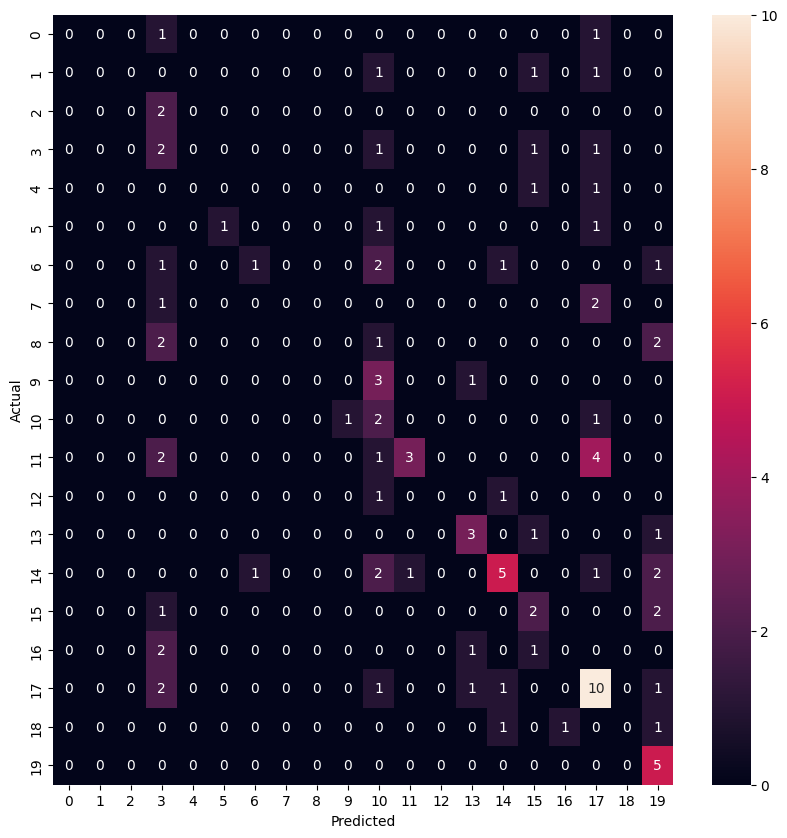

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_test1 = encoder.inverse_transform(y_test)
# y_pred1 = encoder.inverse_transform(y_pred)


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt="d")

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [42]:
# Compute F1 score
f1 = f1_score(y_test, y_pred, average='weighted') 

print("F1 Score:", f1)

F1 Score: 0.29555889654899553


In [43]:
# Save the model to a file
filename = 'model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)
# Load the saved model from file
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)